In [1]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import norm
plt.style.use("/exp/mu2e/data/users/sgrant/mu2e.mplstyle")

In [2]:
# Theoretical Poisson standard error 
def poisson(k, N):
    return np.sqrt(k) / (N)
    
# Wilson uncertainty (half-width) function
def wilson(k, N, z=1.0):  # 68% confidence ⇒ z = 1.0
    alpha = 2 * (1 - norm.cdf(z))
    lower, upper = proportion_confint(k, N, alpha=alpha, method="wilson")
    return (upper - lower) / 2

# Get first time when uncertainty hits target
def get_target_time(t, unc, target=1e-4):
    for i, val in enumerate(unc):
        if np.isnan(val) or val <= 0:
            continue
        if val <= target:
            return t[i]
    return np.nan

/home/sgrant/.conda/envs/ana_v2.1.0/lib/python3.12/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/home/sgrant/.conda/envs/ana_v2.1.0/lib/python3.12/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/home/sgrant/.conda/envs/ana_v2.1.0/lib/python3.12/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/home/sgrant/.conda/envs/ana_v2.1.0/lib/python3.12/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)


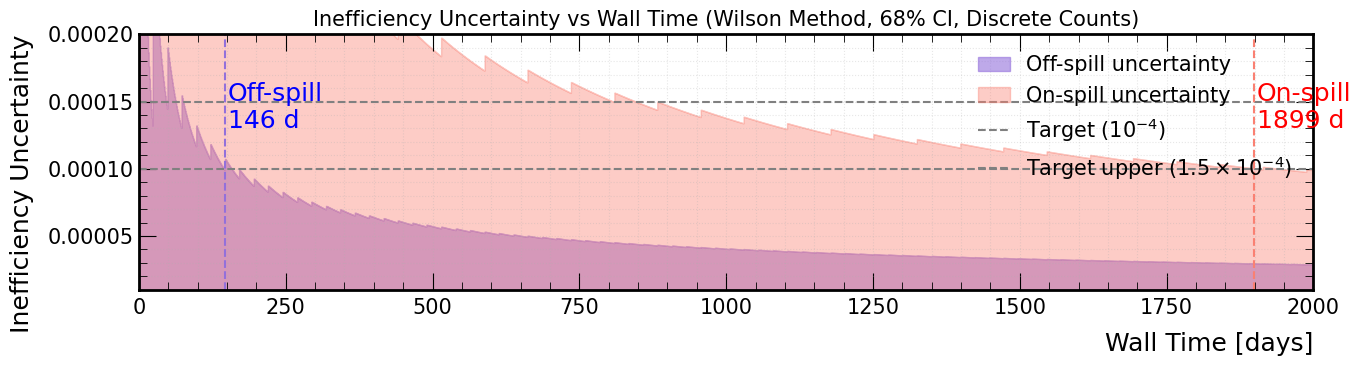

In [3]:
# Constants
live_time_sec = 1.06887e7
livetime_days = live_time_sec / (24 * 3600)

N_b_off, N_ce_off = 7, 27142
N_b_on,  N_ce_on  = 6, 11693

# Rates [events per live-day]
rate_b_off = N_b_off / livetime_days
rate_ce_off = N_ce_off / livetime_days
rate_b_on  = N_b_on  / livetime_days
rate_ce_on  = N_ce_on  / livetime_days

# Wall time range [0–2000 days]
t_wall = np.arange(0, 2001, 1)

# Convert wall time → live time
t_live_off = t_wall * 0.72
t_live_on  = t_wall * 0.28

# Discrete, integer counts
N_b_off_t = np.floor(t_live_off * rate_b_off).astype(int)
N_ce_off_t = np.floor(t_live_off * rate_ce_off).astype(int)
N_b_on_t  = np.floor(t_live_on * rate_b_on).astype(int)
N_ce_on_t  = np.floor(t_live_on * rate_ce_on).astype(int)

# Wilson uncertainties (68% CI ⇒ z=1.0)
unc_off = np.array([wilson(k, N, z=1.0) for k, N in zip(N_b_off_t, N_ce_off_t)])
unc_on  = np.array([wilson(k, N, z=1.0) for k, N in zip(N_b_on_t, N_ce_on_t)])

# Target crossing
target = 1e-4
t_off_target = get_target_time(t_wall, unc_off, target)
t_on_target  = get_target_time(t_wall,  unc_on,  target)

# Plot
fig, ax = plt.subplots(figsize=(14, 4))
# fig, ax = plt.subplots(figsize=(12, 6))
# Fill uncertainty bands
ax.fill_between(t_wall, 0, unc_off, color='mediumpurple', alpha=0.6, step='mid', label="Off-spill uncertainty")
ax.fill_between(t_wall, 0, unc_on, color='salmon', alpha=0.4, step='mid', label="On-spill uncertainty")

# Horizontal target line
# ax.axhline(target, color='gray', linestyle='--', label="Target (10⁻⁴)")
ax.axhline(target, color='gray', linestyle='--', label="Target ($10^{-4}$)")
ax.axhline(target+0.5e-4, color='gray', linestyle='--', label=r"Target upper ($1.5\times10^{-4}$)")
# ax.axhline(target-0.5e-4, color='gray', linestyle='--', label=r"Target ($0.5\times10^{-4}$)")

# Vertical target lines
if not np.isnan(t_off_target):
    # ax.axvline(t_off_target, color='mediumpurple', linestyle='--')
    ax.axvline(t_off_target, color='mediumpurple', linestyle='--')
    ax.text(t_off_target + 5, target*1.3, f"Off-spill\n{int(t_off_target)} d", color='blue')

if not np.isnan(t_on_target):
    ax.axvline(t_on_target, color='salmon', linestyle='--')
    ax.text(t_on_target + 5, target*1.3, f"On-spill\n{int(t_on_target)} d", color='red')

# Formatting
ax.set_xlim(0, 2000)
ax.set_ylim(bottom=1e-5, top=2e-4)
# ax.set_yscale('log')
ax.set_xlabel("Wall Time [days]")
ax.set_ylabel("Inefficiency Uncertainty")
ax.set_title("Inefficiency Uncertainty vs Wall Time (Wilson Method, 68% CI, Discrete Counts)")
ax.legend(loc='upper right')
ax.grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.savefig("../../img/models/plt_victoir_wilson_vs_wall.png") #, dpi=300)
plt.show()

/tmp/ipykernel_982884/125794887.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(k) / (N)


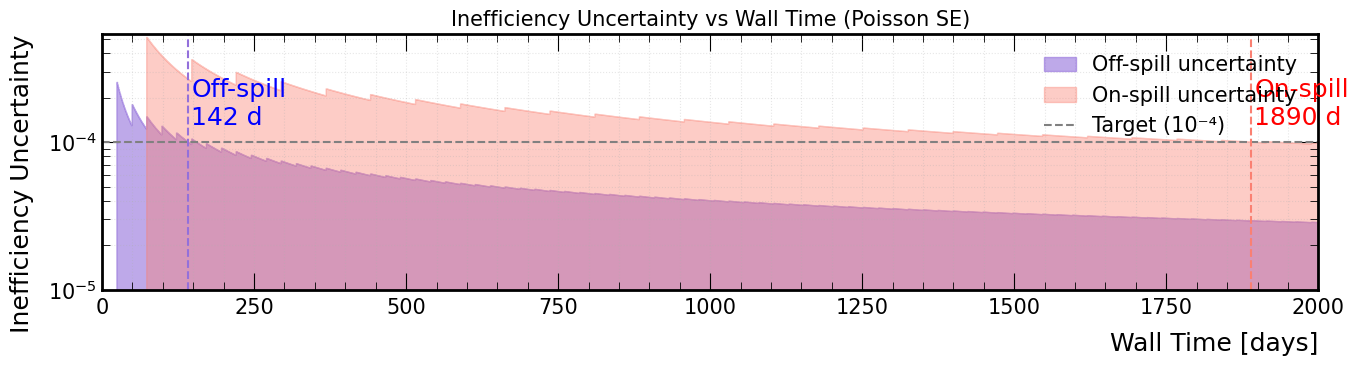

In [4]:
# Wilson uncertainties (68% CI ⇒ z=1.0)
unc_off = np.array([poisson(k, N) for k, N in zip(N_b_off_t, N_ce_off_t)])
unc_on  = np.array([poisson(k, N) for k, N in zip(N_b_on_t, N_ce_on_t)])

# Target crossing
target = 1e-4
t_off_target = get_target_time(t_wall, unc_off, target)
t_on_target  = get_target_time(t_wall,  unc_on,  target)

# Plot
fig, ax = plt.subplots(figsize=(14, 4))

# Fill uncertainty bands
ax.fill_between(t_wall, 0, unc_off, color='mediumpurple', alpha=0.6, step='mid', label="Off-spill uncertainty")
ax.fill_between(t_wall, 0, unc_on, color='salmon', alpha=0.4, step='mid', label="On-spill uncertainty")

# Horizontal target line
ax.axhline(target, color='gray', linestyle='--', label="Target (10⁻⁴)")

# Vertical target lines
if not np.isnan(t_off_target):
    ax.axvline(t_off_target, color='mediumpurple', linestyle='--')
    ax.text(t_off_target + 5, target*1.3, f"Off-spill\n{int(t_off_target)} d", color='blue')

if not np.isnan(t_on_target):
    ax.axvline(t_on_target, color='salmon', linestyle='--')
    ax.text(t_on_target + 5, target*1.3, f"On-spill\n{int(t_on_target)} d", color='red')

# Formatting
ax.set_xlim(0, 2000)
ax.set_ylim(bottom=1e-5)
ax.set_yscale('log')
ax.set_xlabel("Wall Time [days]")
ax.set_ylabel("Inefficiency Uncertainty")
ax.set_title("Inefficiency Uncertainty vs Wall Time (Poisson SE)")
ax.legend(loc='upper right')
ax.grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.savefig("../../img/models/plt_victor_poisson_vs_wall.png") #, dpi=300)
plt.show()

/home/sgrant/.conda/envs/ana_v2.1.0/lib/python3.12/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/home/sgrant/.conda/envs/ana_v2.1.0/lib/python3.12/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/home/sgrant/.conda/envs/ana_v2.1.0/lib/python3.12/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/home/sgrant/.conda/envs/ana_v2.1.0/lib/python3.12/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)


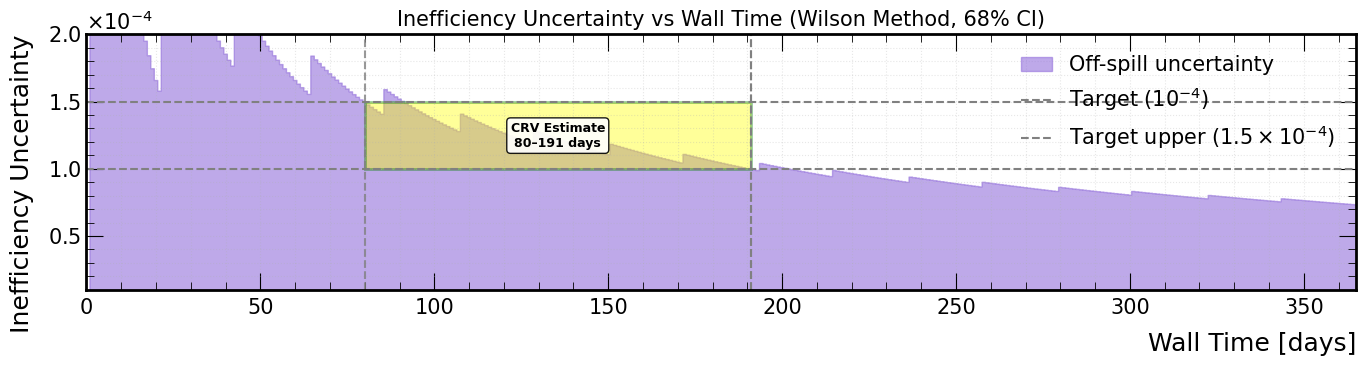

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import norm
from matplotlib.patches import Rectangle
import os 
plt.style.use("/exp/mu2e/data/users/sgrant/mu2e.mplstyle")

# Wilson uncertainty (half-width) function
def wilson(k, N, z=1.0):  # 68% confidence ⇒ z = 1.0
    alpha = 2 * (1 - norm.cdf(z))
    lower, upper = proportion_confint(k, N, alpha=alpha, method="wilson")
    return (upper - lower) / 2

# First time uncertainty hits target
def get_target_time(t, unc, target=1e-4):
    for i, val in enumerate(unc):
        if np.isnan(val) or val <= 0:
            continue
        if val <= target:
            return t[i]
    return np.nan

# Get uncertainty value at target time
def get_uncertainty_at_time(t, unc, target_time):
    if np.isnan(target_time):
        return np.nan
    # Find the index closest to target_time
    idx = np.argmin(np.abs(t - target_time))
    return unc[idx]

# First time it stays under threshold for several consecutive days
def get_consistent_target_time(t, unc, target=1e-4, consecutive_days=5):
    for i in range(len(unc) - consecutive_days + 1):
        if all(not np.isnan(unc[i+j]) and unc[i+j] > 0 and unc[i+j] <= target 
               for j in range(consecutive_days)):
            return t[i]
    return np.nan

# First time it drops below threshold and never rises again
def get_first_permanent_drop_time(t, unc, threshold=1.5e-4):
    for i in range(len(unc)):
        if unc[i] <= threshold:
            if all((np.isnan(u) or u <= threshold) for u in unc[i:]):
                return t[i]
    return np.nan

# Constants
live_time_sec = 1.06887e7
livetime_days = live_time_sec / (24 * 3600)
# N_b_off, N_ce_off = 7, 27142
N_b_off, N_ce_off = 8, 25921 # new cut flow

# Rates [events per live-day]
rate_b_off = N_b_off / livetime_days
rate_ce_off = N_ce_off / livetime_days

# Wall time range [0–2000 days]
t_wall = np.arange(0, 2001, 1)

# Convert wall time → live time
t_live_off = t_wall * 0.72

# Discrete, integer counts
N_b_off_t = np.floor(t_live_off * rate_b_off).astype(int)
N_ce_off_t = np.floor(t_live_off * rate_ce_off).astype(int)

# Wilson uncertainties (68% CI ⇒ z=1.0)
unc_off = np.array([wilson(k, N, z=1.0) for k, N in zip(N_b_off_t, N_ce_off_t)])

# Target crossing
target = 1e-4
target_upper = 1.5e-4
t_off_target = get_target_time(t_wall, unc_off, target)
t_off_target_plus = get_target_time(t_wall, unc_off, target_upper)

# Get the uncertainty value at the target time
unc_at_target_time = get_uncertainty_at_time(t_wall, unc_off, t_off_target)

# Find CRV window
t_crv_start = t_off_target  # Set to 77 days
t_crv_end = t_off_target_plus  # Given endpoint

# Find time when uncertainty drops and stays below threshold permanently
t_crv_permanent = get_first_permanent_drop_time(t_wall, unc_off, threshold=target_upper)

# Plot
fig, ax = plt.subplots(figsize=(14, 4))

# Fill uncertainty bands
ax.fill_between(t_wall, 0, unc_off, color='mediumpurple', alpha=0.6, step='mid', label="Off-spill uncertainty")

# Horizontal target lines
ax.axhline(target, color='gray', linestyle='--', label="Target ($10^{-4}$)")
ax.axhline(target_upper, color='gray', linestyle='--', label=r"Target upper ($1.5\times10^{-4}$)")

# CRV estimate box (yellow) - FIXED
if not np.isnan(t_crv_start) and not np.isnan(t_crv_end) and not np.isnan(unc_at_target_time):
    # Box starts at the uncertainty value at target time and extends 0.5e-4 upward
    box_bottom = unc_at_target_time
    box_height = 0.5e-4
    
    rect = Rectangle(
        (t_crv_start, box_bottom),
        t_crv_end - t_crv_start,
        box_height,
        linewidth=2,
        edgecolor='green',
        facecolor='yellow',
        alpha=0.4
    )
    ax.add_patch(rect)

    ax.axvline(t_crv_start, color='grey', linestyle='--', linewidth=1.5, alpha=0.8)
    ax.axvline(t_crv_end, color='grey', linestyle='--', linewidth=1.5, alpha=0.8)

    # Position text in the middle of the box
    text_y = box_bottom + box_height/2
    ax.text((t_crv_start + t_crv_end) / 2, text_y, 
            f"CRV Estimate\n{int(t_crv_end)}–{int(t_crv_start)} days",
            color='black', fontsize=9, fontweight='bold',
            ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.9))

# Vertical line for permanent drop (now forest green)
# if not np.isnan(t_crv_permanent):
    # ax.axvline(t_crv_permanent, color='darkorange', linestyle='--', linewidth=2)

# Target lines for first crossing
if not np.isnan(t_off_target):
    ax.axvline(t_off_target, color='grey', linestyle='--')
    # ax.text(t_off_target + 5, target * 1.3, color='blue')

# Formatting
ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
ax.set_xlim(0, 365)
ax.set_ylim(bottom=1e-5, top=2e-4)
ax.set_xlabel("Wall Time [days]")
ax.set_ylabel("Inefficiency Uncertainty")
ax.set_title("Inefficiency Uncertainty vs Wall Time (Wilson Method, 68% CI)")
ax.legend(loc='upper right')
ax.grid(True, which='both', alpha=0.3)

import os
os.makedirs("../../img/models", exist_ok=True)

plt.tight_layout()
plt.savefig("../../img/models/IneffUncvsWallTime.png")
plt.show()